This notebook creates tables that go into the main body of the paper.

In [1]:
import sys
import glob
import re
import fnmatch
import math
import datetime
import re
import os
from os import listdir
from os.path import join, isfile, basename

import itertools

import numpy as np
from numpy import float32, int32, uint8, dtype, genfromtxt

from scipy.stats import ttest_ind

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, LogLocator, FormatStrFormatter
%matplotlib inline

sys.path.append("../") # go to parent dir
import template_common as tc

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [29]:
# Global options
write_files_and_tables = False

In [4]:
dist_df, jac_df, hess_df, timeMem_df = tc.readStatTables()
grouped_label_table = tc.groupTables( dist_df, jac_df, hess_df, timeMem_df, tc.template_list  )

../template_common.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['TEMPLATE'] = df.apply(lambda x: template_name(x['TEMPLATE']), axis=1)
../template_common.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['ALG'] = df.apply(lambda x: alg_name(x['ALG']), axis=1)
../template_common.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.

# Skeleton dist stat table
Table 3

In [5]:
# grouped_label_table[ grouped_label_table.CPUTIME_hr_mean == float('nan') ]
# grouped_label_table[ grouped_label_table.ALG == 'Elastix B']

In [6]:
skeleton_dist_stat_f = 'skeleton_dist_stat_raw_%s.tex'%(datetime.date.today().strftime('%Y%m%d'))

cols = ['TEMPLATE', 'ALG','DISTANCE_mean','DISTANCE_std']
antsa_df = grouped_label_table[grouped_label_table.ALG == 'ANTs A'][cols]
cmtka_df = grouped_label_table[grouped_label_table.ALG == 'CMTK A'][cols]
elastixa_df = grouped_label_table[grouped_label_table.ALG == 'Elastix A'][cols]

# Choose the algorithm that works best per template
best_df = grouped_label_table.sort_values('DISTANCE_mean') \
    .groupby('TEMPLATE', as_index=False) \
    .first()[cols]

# combine these four tables
# The names of the columns for the 'best
total_table = best_df.set_index('TEMPLATE') \
    .join( antsa_df.set_index('TEMPLATE'), rsuffix='_antsA') \
    .join( cmtka_df.set_index('TEMPLATE'), rsuffix='_cmtkA') \
    .join( elastixa_df.set_index('TEMPLATE'), rsuffix='_elastixA') \
    .reset_index()

# Format the columns nicely
tc.meanStdStringCol( total_table, 'Best', 'DISTANCE_mean', 'DISTANCE_std')
tc.meanStdStringCol( total_table, 'ANTs A', 'DISTANCE_mean_antsA', 'DISTANCE_std_antsA')
tc.meanStdStringCol( total_table, 'CMTK A', 'DISTANCE_mean_cmtkA', 'DISTANCE_std_cmtkA')
tc.meanStdStringCol( total_table, 'Elastix A', 'DISTANCE_mean_elastixA', 'DISTANCE_std_elastixA')


skel_dist_table = total_table[['TEMPLATE','ALG','Best','ANTs A','CMTK A','Elastix A']].sort_values('Best')


if( write_files_and_tables ):
    print( 'writing : ', skeleton_dist_stat_f )
    with open( skeleton_dist_stat_f, 'w') as f:
        f.write( skel_dist_table.to_latex())
        
skel_dist_table

,TEMPLATE,ALG,Best,ANTs A,CMTK A,Elastix A
3,JRC2018,ANTs A,3.97 (3.65),3.97 (3.65),4.03 (3.70),4.05 (3.73)
4,Tefor,ANTs A,4.00 (3.68),4.00 (3.68),5.44 (5.75),4.12 (3.69)
2,JFRC2013,Elastix A,4.06 (3.68),4.15 (3.84),4.73 (4.71),4.06 (3.68)
1,JFRC2010,Elastix A,4.11 (3.68),6.31 (6.20),5.69 (5.50),4.11 (3.68)
0,FCWB,ANTs A,4.35 (3.97),4.35 (3.97),5.52 (4.97),6.18 (5.93)


## Jacobian determinant 

Table 4

In [7]:
# grouped_label_table.head()
smoothness_stat_f = 'smoothness_stat_raw_%s.tex'%(datetime.date.today().strftime('%Y%m%d'))

sm_cols = ['TEMPLATE', 'ALG','JAC_std','HES_mean', 'DISTANCE_mean']
sm_antsa_df = grouped_label_table[grouped_label_table.ALG == 'ANTs A'][sm_cols]
sm_cmtka_df = grouped_label_table[grouped_label_table.ALG == 'CMTK A'][sm_cols]
sm_elastixa_df = grouped_label_table[grouped_label_table.ALG == 'Elastix A'][sm_cols]

sm_best_df = grouped_label_table.sort_values('DISTANCE_mean') \
    .groupby('TEMPLATE', as_index=False) \
    .first()[sm_cols]
    
sm_total_table = sm_best_df.set_index('TEMPLATE') \
    .join( sm_antsa_df.set_index('TEMPLATE'), rsuffix='_antsA') \
    .join( sm_cmtka_df.set_index('TEMPLATE'), rsuffix='_cmtkA') \
    .join( sm_elastixa_df.set_index('TEMPLATE'), rsuffix='_elastixA') \
    .reset_index()
    

smooth_stat_table = sm_total_table[['TEMPLATE',
                                'JAC_std','JAC_std_antsA','JAC_std_cmtkA','JAC_std_elastixA',
                                'HES_mean', 'HES_mean_antsA', 'HES_mean_cmtkA', 'HES_mean_elastixA'
                              ]]


if( write_files_and_tables ):
    print( 'writing : ', smoothness_stat_f )
    with open( smoothness_stat_f, 'w') as f:
        f.write( smooth_stat_table.to_latex())

smooth_stat_table

,TEMPLATE,JAC_std,JAC_std_antsA,JAC_std_cmtkA,JAC_std_elastixA,HES_mean,HES_mean_antsA,HES_mean_cmtkA,HES_mean_elastixA
0,FCWB,0.472733,0.472733,0.322697,0.232061,0.051439,0.051439,0.037568,0.004664
1,JFRC2010,0.148218,0.262951,0.187527,0.148218,0.002918,0.032314,0.014020,0.002918
2,JFRC2013,0.232311,0.225148,0.261545,0.232311,0.013140,0.039004,0.017099,0.013140
3,JRC2018,0.205782,0.205782,0.205730,0.166908,0.034794,0.034794,0.024503,0.017539
4,Tefor,0.256788,0.256788,0.233974,0.138331,0.040668,0.040668,0.018976,0.003300


## Distance vs Jacobian
Figure 5

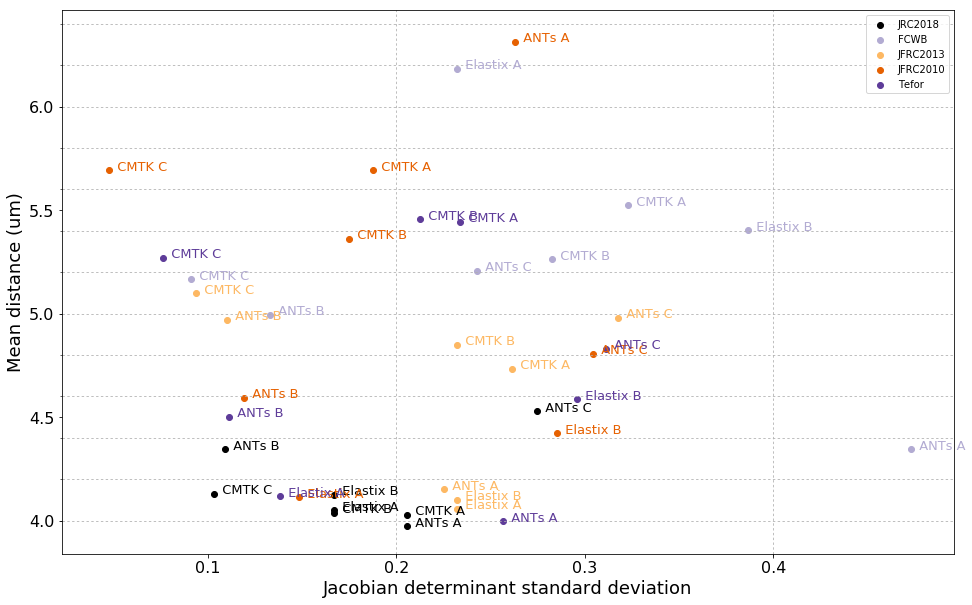

In [8]:
fout_prefix='distWarpNorm_vs_Jacobian_raw_%s'%(datetime.date.today().strftime('%Y%m%d'))

ax = tc.make_scatter_plot( grouped_label_table, 'JAC_std', 'DISTANCE_mean' )

ax.xaxis.set_minor_locator( MultipleLocator(0.2) )
ax.yaxis.set_minor_locator( MultipleLocator(0.2) )
plt.grid( which='minor', linestyle=':', dashes=(3,3))

plt.xlabel('Jacobian determinant standard deviation', size=18)
plt.ylabel('Mean distance (um)', size=18)

fig = plt.gcf()
a = fig.set_size_inches( 16, 10 ) 

if( write_files_and_tables ):
    print( 'writing : ', fout_prefix )
    plt.savefig(fout_prefix+".svg")
    plt.savefig(fout_prefix+".pdf")
    plt.savefig(fout_prefix+".png")

## Distance vs Hessian
Figure 5a

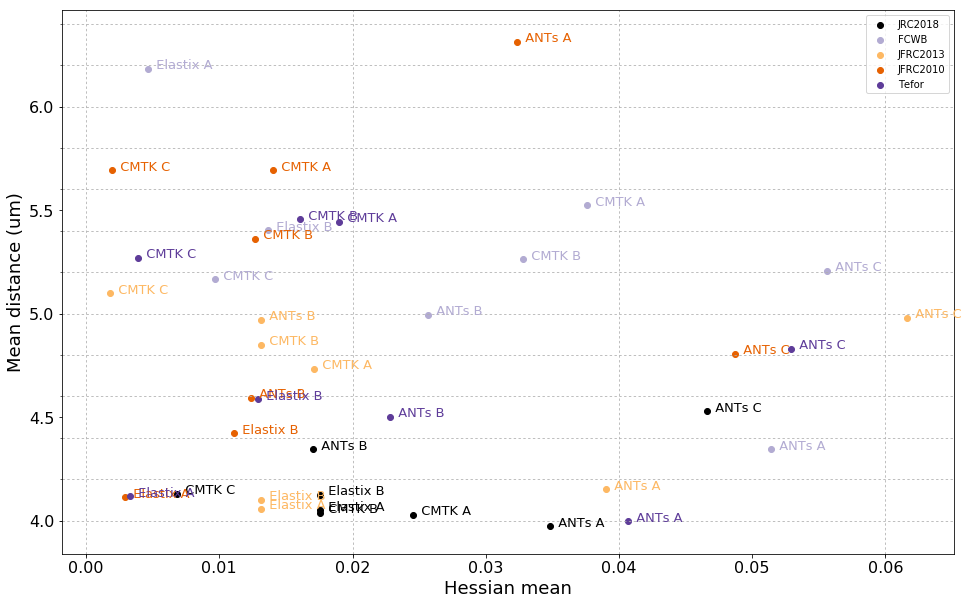

In [9]:
fout_prefix='distWarpNorm_vs_Hessian_raw_%s'%(datetime.date.today().strftime('%Y%m%d'))


ax = tc.make_scatter_plot( grouped_label_table, 'HES_mean', 'DISTANCE_mean' )

ax.xaxis.set_minor_locator( MultipleLocator(0.02) )
ax.yaxis.set_minor_locator( MultipleLocator(0.2) )
plt.grid( which='minor', linestyle=':', dashes=(3,3))

plt.xlabel('Hessian mean', size=18)
plt.ylabel('Mean distance (um)', size=18)

fig = plt.gcf()
a = fig.set_size_inches( 16, 10 ) 

if( write_files_and_tables ):
    print( 'writing : ', fout_prefix )
    plt.savefig(fout_prefix+".svg")
    plt.savefig(fout_prefix+".pdf")
    plt.savefig(fout_prefix+".png")

## Jacobian vs Hessian
Figure 5c

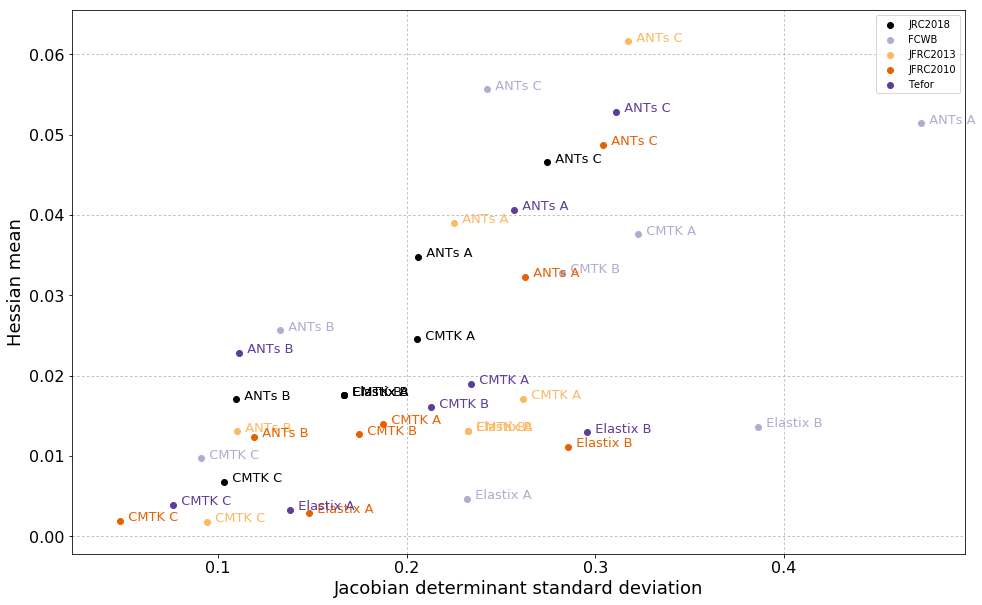

In [10]:
fout_prefix='Hessian_vs_Jacobian_raw_%s'%(datetime.date.today().strftime('%Y%m%d'))


ax = tc.make_scatter_plot( grouped_label_table, 'JAC_std', 'HES_mean')

ax.xaxis.set_minor_locator( MultipleLocator(0.2) )
ax.yaxis.set_minor_locator( MultipleLocator(0.02) )
plt.grid( which='minor', linestyle=':', dashes=(3,3))

plt.xlabel('Jacobian determinant standard deviation', size=18)
plt.ylabel('Hessian mean', size=18)

fig = plt.gcf()
a = fig.set_size_inches( 16, 10 )

if( write_files_and_tables ):
    print( 'writing : ', fout_prefix )
    plt.savefig(fout_prefix+".svg")
    plt.savefig(fout_prefix+".pdf")
    plt.savefig(fout_prefix+".png")

## Distance vs CpuTime
Figure 6

In [22]:
# grouped_label_table.head()

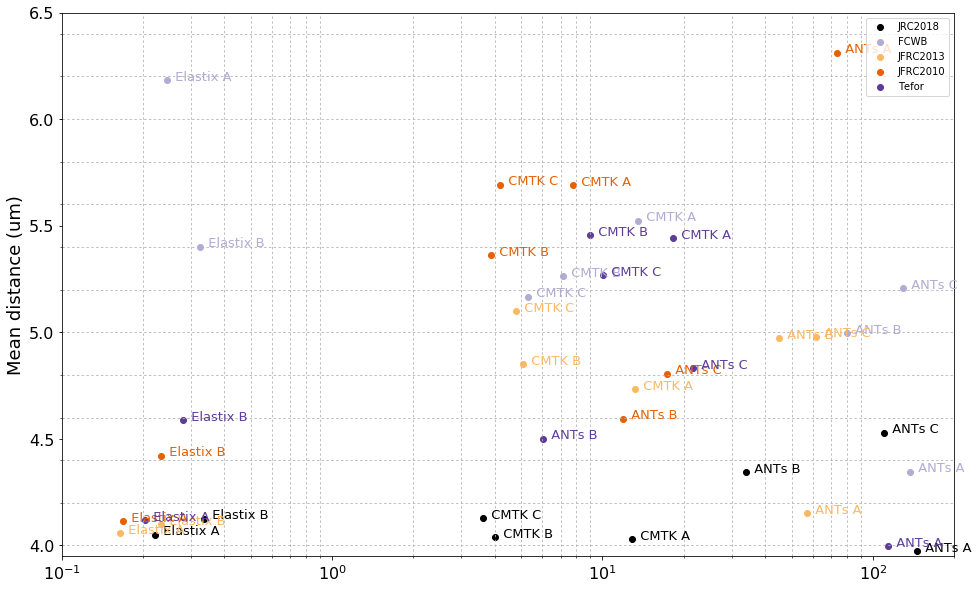

In [12]:
# Big figure

fout_prefix='distWarpNorm_vs_cputime_raw_%s'%(datetime.date.today().strftime('%Y%m%d'))


ax = tc.make_scatter_plot( grouped_label_table, 'CPUTIME_hr_mean', 'DISTANCE_mean')

ax.yaxis.set_minor_locator( MultipleLocator(0.2) )
plt.grid( which='minor', linestyle=':', dashes=(3,3))

ax.set_xscale('log')
plt.xlim(0.1,200)
plt.ylim(3.95,6.5)


plt.ylabel('CPU hours', size=18)
plt.ylabel('Mean distance (um)', size=18)

fig = plt.gcf()
a = fig.set_size_inches( 16, 10 )

if( write_files_and_tables ):
    print( 'writing : ', fout_prefix )
    plt.savefig(fout_prefix+".svg")
    plt.savefig(fout_prefix+".pdf")
    plt.savefig(fout_prefix+".png")

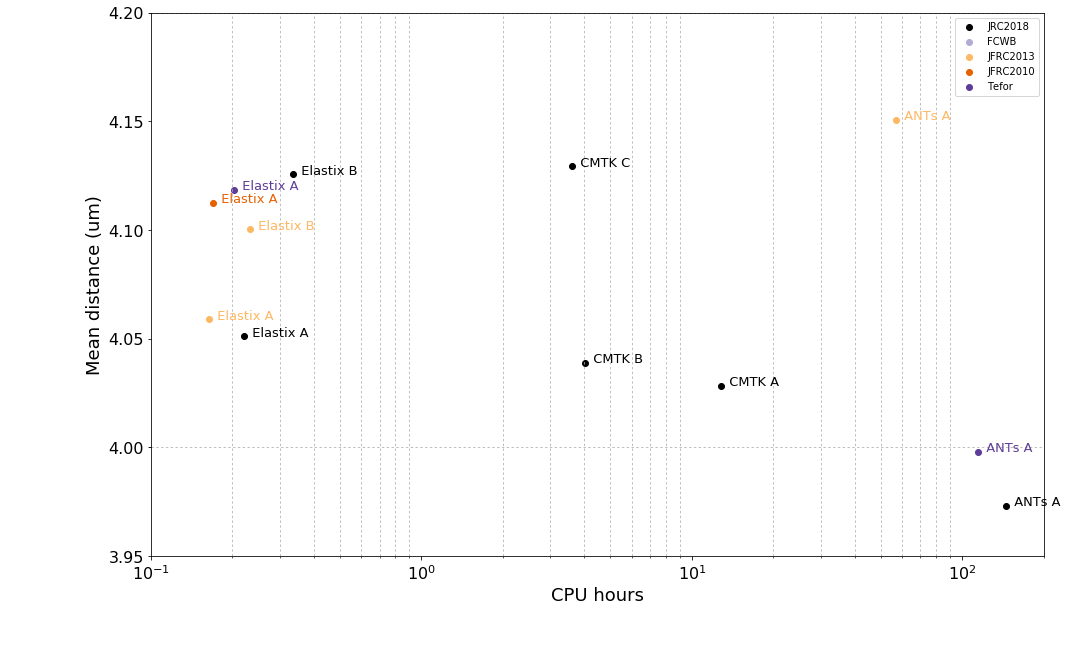

In [13]:
# Big figure

fout_prefix='distWarpNorm_vs_cputime_best_raw_%s'%(datetime.date.today().strftime('%Y%m%d'))


ax = tc.make_scatter_plot( grouped_label_table, 'CPUTIME_hr_mean', 'DISTANCE_mean')

ax.yaxis.set_minor_locator( MultipleLocator(0.2) )
plt.grid( which='minor', linestyle=':', dashes=(3,3))

ax.set_xscale('log')

plt.xlim(0.1,200)
plt.ylim(3.95,4.2)

# ax.xaxis.set_minor_locator( MultipleLocator(0.2) )
# ax.yaxis.set_minor_locator( MultipleLocator(0.02) )
# plt.grid( which='minor', linestyle=':', dashes=(3,3))

plt.xlabel('CPU hours', size=18)
plt.ylabel('Mean distance (um)', size=18)

fig = plt.gcf()
a = fig.set_size_inches( 16, 10 )

if( write_files_and_tables ):
    print( 'writing : ', fout_prefix )
    plt.savefig(fout_prefix+".svg")
    plt.savefig(fout_prefix+".pdf")
    plt.savefig(fout_prefix+".png")

## Skeleton distance stats table
Table 7

In [20]:
dist_stat_f = 'distWarpStats_table_raw_%s.tex'%(datetime.date.today().strftime('%Y%m%d'))

table7 = dist_df[ (dist_df.LABEL==-1) & \
                 ((dist_df.normalization=='warp') | (dist_df.normalization=='na'))]

tmask = table7.apply(lambda x: x['TEMPLATE'] in tc.template_list, axis=1)
table7 = table7.loc[tmask]
table7 = table7.reset_index( drop=True )

table7['TEMPLATE'] = table7.apply(lambda x: tc.template_name(x['TEMPLATE']), axis=1)
table7['ALG'] = table7.apply(lambda x: tc.alg_name(x['ALG']), axis=1)

table7 = table7[['TEMPLATE','ALG','DISTANCE_mean', 'DISTANCE_std', 'DISTANCE_median']] \
    .reset_index( drop=True ) \
    .sort_values( by=['DISTANCE_mean'] )


if( write_files_and_tables ):
    print( 'writing : ', dist_stat_f )
    with open( dist_stat_f, 'w') as f:
        f.write( table7.to_latex())
        
table7

,TEMPLATE,ALG,DISTANCE_mean,DISTANCE_std,DISTANCE_median
0,JRC2018,ANTs A,3.973258748984814,3.651041,3.0822069644927983
32,Tefor,ANTs A,3.9980898615010507,3.677006,3.1622776985168457
3,JRC2018,CMTK A,4.028416676722988,3.700395,3.1622776985168457
5,JRC2018,CMTK B,4.03905262551913,3.702696,3.1622776985168457
7,JRC2018,Elastix A,4.051037906746626,3.733471,3.240370273590088
23,JFRC2013,Elastix A,4.058863643692604,3.679679,3.240370273590088
22,JFRC2013,Elastix B,4.100456562959735,3.726137,3.240370273590088
31,JFRC2010,Elastix A,4.112502848886199,3.678956,3.240370273590088
39,Tefor,Elastix A,4.118549223182261,3.692219,3.240370273590088
6,JRC2018,Elastix B,4.125639168797318,3.775759,3.240370273590088


## Smoothness stats table
Table 8

In [21]:
smooth_stat_f = 'smoothnessStats_table_raw_%s.tex'%(datetime.date.today().strftime('%Y%m%d'))

jac_df_clean = tc.clean_names( jac_df ).loc[ jac_df.label == -1 ]
hess_df_clean = tc.clean_names( hess_df ).loc[ hess_df.label == -1 ]

# hess_df_clean
# jac_df_clean

sm_table = jac_df_clean.set_index('TA').join( hess_df_clean.set_index('TA'), lsuffix='_j' )

tc.meanStdStringCol( sm_table, 'JACMeanStd', 'JAC_mean', 'JAC_std', formatstring='%0.4f (%0.4f)')
tc.meanStdStringCol( sm_table, 'HESMeanStd', 'HES_mean', 'HES_std', formatstring='%0.4f (%0.4f)')

table8 = sm_table[['TEMPLATE','ALG','JACMeanStd', 'HESMeanStd']]
# sm_table = sm_table.groupby(['TEMPLATE','ALG'])
table8.reset_index( drop=True)


if( write_files_and_tables ):
    print( 'writing : ', smooth_stat_f )
    with open( smooth_stat_f, 'w') as f:
        f.write( table8.to_latex())

table8

,TEMPLATE,ALG,JACMeanStd,HESMeanStd
TA,,,,
JRC2018:ANTs A,JRC2018,ANTs A,1.0087 (0.2058),0.0348 (0.0286)
JRC2018:ANTs B,JRC2018,ANTs B,0.9810 (0.1092),0.0171 (0.0152)
JRC2018:ANTs C,JRC2018,ANTs C,0.9756 (0.2745),0.0466 (0.0416)
JRC2018:CMTK A,JRC2018,CMTK A,1.0303 (0.2057),0.0245 (0.0226)
JRC2018:CMTK C,JRC2018,CMTK C,1.0189 (0.1031),0.0068 (0.0069)
JRC2018:CMTK B,JRC2018,CMTK B,1.0270 (0.1669),0.0175 (0.0172)
JRC2018:Elastix B,JRC2018,Elastix B,1.0270 (0.1669),0.0175 (0.0172)
JRC2018:Elastix A,JRC2018,Elastix A,1.0270 (0.1669),0.0175 (0.0172)
FCWB:ANTs A,FCWB,ANTs A,0.9975 (0.4727),0.0514 (0.0539)


# Dist v Jacobian - Affine normalization
Figure 9

In [16]:
statdir='/nrs/saalfeld/john/projects/flyChemStainAtlas/all_evals/stats_2019Jul'
dist_all_df, jac_all_df, hess_all_df, timeMem_all_df = tc.readStatTables( statdir )

dist_aff_df = dist_all_df[ (dist_all_df.normalization=='affine') | (dist_all_df.normalization=='na')]
aff_grouped_df = tc.groupTables( dist_aff_df, jac_all_df, hess_all_df, timeMem_all_df, tc.template_list  )


../template_common.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['TEMPLATE'] = df.apply(lambda x: template_name(x['TEMPLATE']), axis=1)
../template_common.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['ALG'] = df.apply(lambda x: alg_name(x['ALG']), axis=1)
../template_common.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.

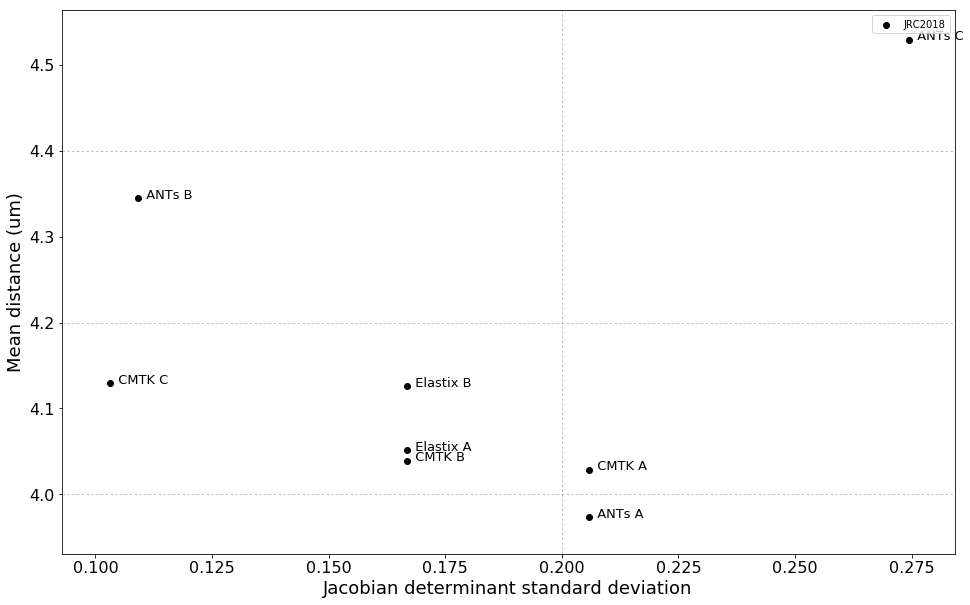

In [17]:
fout_prefix='distAffineNorm_vs_jacStd_raw_%s'%(datetime.date.today().strftime('%Y%m%d'))


ax = tc.make_scatter_plot( aff_grouped_df, 'JAC_std', 'DISTANCE_mean')

ax.xaxis.set_minor_locator( MultipleLocator(0.2) )
ax.yaxis.set_minor_locator( MultipleLocator(0.2) )
plt.grid( which='minor', linestyle=':', dashes=(3,3))

plt.xlabel('Jacobian determinant standard deviation', size=18)
plt.ylabel('Mean distance (um)', size=18)

fig = plt.gcf()
a = fig.set_size_inches( 16, 10 ) 

if( write_files_and_tables ):
    print( 'writing : ', fout_prefix )
    plt.savefig(fout_prefix+".svg")
    plt.savefig(fout_prefix+".pdf")
    plt.savefig(fout_prefix+".png")

## Dist v Speed - by Resolution
Figure 10 and Table 6

In [42]:
cmv = plt.cm.get_cmap('viridis')
cmm = plt.cm.get_cmap('magma')
cmp = plt.cm.get_cmap('plasma')

template_color_map_res_raw = { 
                      'Tefor':cmv(0.2),
                      'TeforBrain_f':cmv(0.2),
                      'TeforBrain_1p2iso':cmv(0.4),
                      'TeforBrain_2p4iso':cmv(0.6),
                      'TeforBrain_3p6iso':cmv(0.8),
                      'JRC2018':cmp(0.1),
                      'F-antsFlip_lo':cmp(0.2),
                      'F-antsFlip_lof':cmp(0.2),
                      'jrc18_0p6':cmp(0.2),
                      'jrc18_1p2':cmp(0.4),
                      'jrc18_2p4':cmp(0.6),
                      'jrc18_3p6':cmp(0.8),
                     }
legend_order = ['JRC2018', 'JFRC2018 (1.2um)', 'JFRC2018 (2.4um)','JFRC2018 (3.6um)', \
                'Tefor', 'Tefor (1.2um)', 'Tefor (2.4um)', 'Tefor (3.6um)']

In [25]:
template_color_map_res = {}
for k in template_color_map_res_raw.keys():
    template_color_map_res[ tc.template_name(k) ] = template_color_map_res_raw[k]
    
template_color_map_res

{'JFRC2018 (1.2um)': (0.69284, 0.165141, 0.564522, 1.0),
 'JFRC2018 (2.4um)': (0.881443, 0.392529, 0.383229, 1.0),
 'JFRC2018 (3.6um)': (0.98826, 0.652325, 0.211364, 1.0),
 'JRC2018': (0.417642, 0.000564, 0.65839, 1.0),
 'Tefor': (0.253935, 0.265254, 0.529983, 1.0),
 'Tefor (1.2um)': (0.163625, 0.471133, 0.558148, 1.0),
 'Tefor (2.4um)': (0.134692, 0.658636, 0.517649, 1.0),
 'Tefor (3.6um)': (0.477504, 0.821444, 0.318195, 1.0),
 'jrc18_0p6': (0.417642, 0.000564, 0.65839, 1.0)}

In [26]:
# Grouped table for resolution table / figure

## TODO get tc.groupTables to work for this

# filter templates
tmask = dist_df.apply( lambda x: (x['TEMPLATE'] in tc.template_list_res ), axis=1)
df = dist_df.loc[tmask]

# Filter out appropriate rows and columns
dist_table = df.loc[ (df.LABEL == -1) & (df.ALG != 'ALL') & \
                    ((df.normalization == 'warp') | (df.normalization == 'na'))][['ALG','TEMPLATE','DISTANCE_mean','DISTANCE_std']]

dist_table = tc.clean_names( dist_table )

# Tabulate times
timeMem_df['CPUTIME'] = timeMem_df.apply(lambda x: float(x['runtime'])*float(x['numThreads']), axis=1) 
timeMem_df['CPUTIME_hr'] = timeMem_df.apply(lambda x: float( x['CPUTIME']) / 3600., axis=1) 

times_stats = timeMem_df.groupby(['ALG','TEMPLATE']).agg({'CPUTIME_hr' : ['mean','median','var']})
times_stats_flat = pd.DataFrame(times_stats.to_records())

newcols = [ re.sub('[\'(),]','', c ).replace( ' ', '_') for c in times_stats_flat.columns ]
times_stats_flat.columns = newcols
times_stats_flat['ALG'] = times_stats_flat.apply(lambda x: tc.alg_name(x['ALG']), axis=1)
times_stats_flat['CPUTIME_hr_sd'] = times_stats_flat.apply(lambda x: float(math.sqrt(x['CPUTIME_hr_var'])), axis=1)
times_stats_flat['TEMPLATE'] = times_stats_flat.apply(lambda x: tc.template_name(x['TEMPLATE']), axis=1)
times_stats_flat['TA'] = times_stats_flat.apply(lambda x: ''.join([x['TEMPLATE'],':',x['ALG']]), axis=1)
time_table = times_stats_flat

tmp_tbl = dist_table.set_index('TA').join( time_table.set_index('TA'), lsuffix='_dist')
res_grouped_label_table = tmp_tbl.reset_index()[['ALG','TEMPLATE','CPUTIME_hr_mean','CPUTIME_hr_sd','DISTANCE_mean','DISTANCE_std']]
res_grouped_label_table['DISTANCE_mean'] = res_grouped_label_table.apply(lambda x: float(x['DISTANCE_mean']), axis=1)
# res_grouped_label_table

# dm = pd.to_numeric( dist_df['DISTANCE_mean'])

# # middle = 4.217455
# # middle = 4.086319
# middle = 4.647281
# eps = 0.000001

# i = (dm > (middle-eps)) & (dm < (middle+eps))
# i.describe()

# dist_df[ i ][['TEMPLATE','ALG']]
# # dist_all_df[ (dist_all_df.DISTANCE_mean > 4.217454) & (dist_all_df.DISTANCE_mean < 4.217456)]

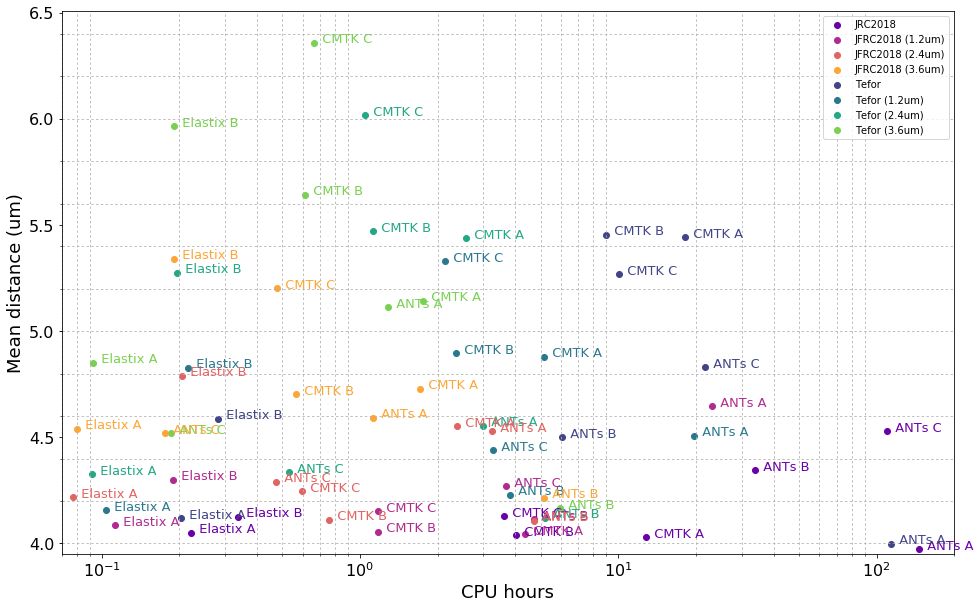

In [45]:
res_dist_speed_stat_f = 'res_speed_quality_raw_%s.tex'%(datetime.date.today().strftime('%Y%m%d'))


ax = tc.make_scatter_plot( res_grouped_label_table, 'CPUTIME_hr_mean', 'DISTANCE_mean',
                         color_map=template_color_map_res)

ax.yaxis.set_minor_locator( MultipleLocator(0.2) )
plt.grid( which='minor', linestyle=':', dashes=(3,3))

ax.set_xscale('log')
plt.xlabel('CPU hours', size=18)
plt.ylabel('Mean distance (um)', size=18)

indices = [ legend_labels.index( t ) for t in legend_order ]
legend_labels_new = [ legend_labels[i] for i in indices]
legend_handles_new = [ legend_handles[i] for i in indices]
ax.legend( legend_handles_new, legend_labels_new )

plt.xlim(0.07,200)
plt.ylim(3.95,6.51)

fig = plt.gcf()
a = fig.set_size_inches( 16, 10 ) 

if( write_files_and_tables ):
    print( 'writing : ', res_dist_speed_stat_f )
    plt.savefig(res_dist_speed_stat_f+".svg")
    plt.savefig(res_dist_speed_stat_f+".pdf")
    plt.savefig(res_dist_speed_stat_f+".png")